In [3]:
import os
import opendatasets as od
import pandas as pd
from zipfile import ZipFile
import numpy as np
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt

The goal is to predict the Weekly Sales of Walmart specific stores, departments and dates.

In [8]:
dataset_url = 'https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting'
od.download('https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting')

Skipping, found downloaded files in "./walmart-recruiting-store-sales-forecasting" (use force=True to force download)


In [7]:
os.listdir('walmart-recruiting-store-sales-forecasting')

['features.csv.zip',
 'sampleSubmission.csv.zip',
 'test.csv.zip',
 'train.csv.zip',
 'stores.csv']

**1. stores.csv:** This file contains anonymized information about the 45 stores, indicating the type and size of store.


**2. train.csv:** This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file we will find the following fields:
- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week

**3. test.csv:** This file is identical to train.csv, except we have withheld the weekly sales. We must predict the sales for each triplet of store, department, and date in this file.


**4. features.csv:** This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:
- Store - the store number
- Date - the week
- Temperature - average temperature in the region
- Fuel_Price - cost of fuel in the region
- MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
- CPI - the consumer price index
- Unemployment - the unemployment rate
- IsHoliday - whether the week is a special holiday week

In [9]:
train_zip_file = ZipFile('walmart-recruiting-store-sales-forecasting/train.csv.zip')
features_zip_file = ZipFile('walmart-recruiting-store-sales-forecasting/features.csv.zip')
test_zip_file = ZipFile('walmart-recruiting-store-sales-forecasting/test.csv.zip')
sample_submission_zip_file = ZipFile('walmart-recruiting-store-sales-forecasting/sampleSubmission.csv.zip')

In [10]:
train_df = pd.read_csv(train_zip_file.open('train.csv'))
features_df = pd.read_csv(features_zip_file.open('features.csv'))
stores_df = pd.read_csv('walmart-recruiting-store-sales-forecasting/stores.csv')
test_df = pd.read_csv(test_zip_file.open('test.csv'))
submission_df = pd.read_csv(sample_submission_zip_file.open('sampleSubmission.csv'))

In [11]:
dataset = train_df.merge(stores_df, how='left').merge(features_df, how='left')
test_dataset = test_df.merge(stores_df, how='left').merge(features_df, how='left')

# Data exploration

In [12]:
dataset.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


# The Target variable is Weekly_Sales

In [14]:
dataset.describe(include = 'all')

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,421570.000000,421570.000000,421570,421570.000000,421570,421570,421570.000000,421570.000000,421570.000000,150681.000000,111248.000000,137091.000000,134967.000000,151432.000000,421570.000000,421570.000000
unique,NaN,NaN,143,NaN,2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,2011-12-23,NaN,False,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,3027,NaN,391909,215478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,22.200546,44.260317,NaN,15981.258123,NaN,NaN,136727.915739,60.090059,3.361027,7246.420196,3334.628621,1439.421384,3383.168256,4628.975079,171.201947,7.960289
std,12.785297,30.492054,NaN,22711.183519,NaN,NaN,60980.583328,18.447931,0.458515,8291.221345,9475.357325,9623.078290,6292.384031,5962.887455,39.159276,1.863296
min,1.000000,1.000000,NaN,-4988.940000,NaN,NaN,34875.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000
25%,11.000000,18.000000,NaN,2079.650000,NaN,NaN,93638.000000,46.680000,2.933000,2240.270000,41.600000,5.080000,504.220000,1878.440000,132.022667,6.891000
50%,22.000000,37.000000,NaN,7612.030000,NaN,NaN,140167.000000,62.090000,3.452000,5347.450000,192.000000,24.600000,1481.310000,3359.450000,182.318780,7.866000
75%,33.000000,74.000000,NaN,20205.852500,NaN,NaN,202505.000000,74.280000,3.738000,9210.900000,1926.940000,103.990000,3595.040000,5563.800000,212.416993,8.572000


### Null Values

In [15]:
dataset.isnull().mean() * 100

Store            0.000000
Dept             0.000000
Date             0.000000
Weekly_Sales     0.000000
IsHoliday        0.000000
Type             0.000000
Size             0.000000
Temperature      0.000000
Fuel_Price       0.000000
MarkDown1       64.257181
MarkDown2       73.611025
MarkDown3       67.480845
MarkDown4       67.984676
MarkDown5       64.079038
CPI              0.000000
Unemployment     0.000000
dtype: float64

Input Variables Correlation with the output feature Weekly_Sales

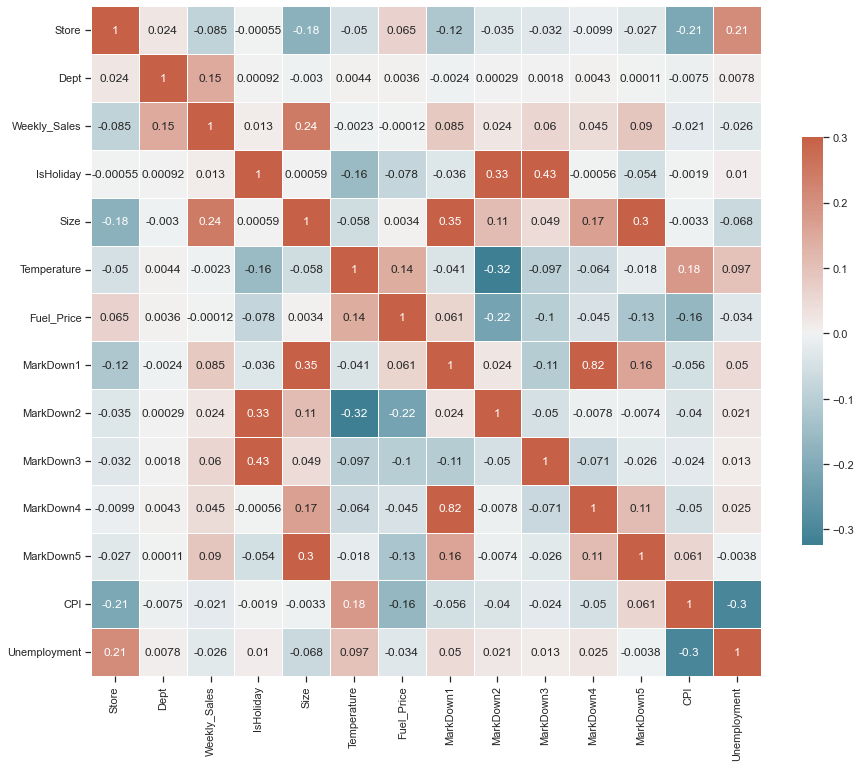

In [16]:
corr = dataset.corr()
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={'shrink': .5})
plt.show()

By watching the correlation matrix, we can see that Weekly_Sales have a higher correlation with Store, Dept and Size.
We will drop the variables with lower correlation in the Data Manipulation section.

### Data Manipulation

In [17]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

Now, we will do the following steps:
* Remove null values from the markdown variables.
* Create variables for year, month and week, based on the date field.
* Remove the variables with low correlation.

In [18]:
dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
dataset['Year'] = pd.to_datetime(dataset['Date']).dt.year
dataset['Month'] = pd.to_datetime(dataset['Date']).dt.month
dataset['Week'] = pd.to_datetime(dataset['Date']).dt.isocalendar().week
dataset = dataset.drop(columns=["Date", "CPI", "Fuel_Price", 'Unemployment', 'Temperature'])

In [21]:
dataset.head(10)

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Year,Month,Week
0,1,1,24924.50,False,A,151315,0.0,0.0,0.0,0.0,0.0,2010,2,5
1,1,1,46039.49,True,A,151315,0.0,0.0,0.0,0.0,0.0,2010,2,6
2,1,1,41595.55,False,A,151315,0.0,0.0,0.0,0.0,0.0,2010,2,7
3,1,1,19403.54,False,A,151315,0.0,0.0,0.0,0.0,0.0,2010,2,8
4,1,1,21827.90,False,A,151315,0.0,0.0,0.0,0.0,0.0,2010,3,9
5,1,1,21043.39,False,A,151315,0.0,0.0,0.0,0.0,0.0,2010,3,10
6,1,1,22136.64,False,A,151315,0.0,0.0,0.0,0.0,0.0,2010,3,11
7,1,1,26229.21,False,A,151315,0.0,0.0,0.0,0.0,0.0,2010,3,12
8,1,1,57258.43,False,A,151315,0.0,0.0,0.0,0.0,0.0,2010,4,13
9,1,1,42960.91,False,A,151315,0.0,0.0,0.0,0.0,0.0,2010,4,14


In [22]:
# Moving the target variable to the last column
df = dataset.pop('Weekly_Sales')
dataset['Weekly_Sales'] = df

In [24]:
# Identify target and input columns
input_cols, target_col = dataset.columns[:-1], dataset.columns[-1]
inputs_df, targets = dataset[input_cols].copy(), dataset[target_col].copy()

In [25]:
# Identify categorical and numerique columns
numeric_cols = dataset[input_cols].select_dtypes(include=np.number).columns.tolist()
categorical_cols = dataset[input_cols].select_dtypes(include='object').columns.tolist()

In [27]:
# Fill and scale numeric columns
imputer = SimpleImputer().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = imputer.transform(inputs_df[numeric_cols])
scaler = MinMaxScaler().fit(inputs_df[numeric_cols])
inputs_df[numeric_cols] = scaler.transform(inputs_df[numeric_cols])

In [28]:
# one hot encoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names(categorical_cols))
inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])

/opt/homebrew/Caskroom/miniforge/base/envs/ground_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [29]:
# Spliting the dataset into train and test
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs_df[numeric_cols + encoded_cols], targets, test_size=0.25, random_state=42)

### Models

#### Decision Tree

In [37]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [32]:
tree = DecisionTreeRegressor(random_state=0)

In [34]:
# Fit the model
tree.fit(train_inputs, train_targets)

DecisionTreeRegressor(random_state=0)

In [41]:
#We generate predictions on the training and validation sets using the trained decision tree, and compute the Root Mean Squared Error (RMSE) loss.
tree_train_preds = tree.predict(train_inputs)
tree_train_rmse = mean_squared_error(train_targets, tree_train_preds, squared=False)
tree_val_preds = tree.predict(val_inputs)
tree_val_rmse = mean_squared_error(val_targets, tree_val_preds, squared=False)
print('Train RMSE: {}, Validation RMSE: {}'.format(tree_train_rmse, tree_val_rmse))

Train RMSE: 7.658932626616451e-19, Validation RMSE: 5365.010717466009


In [ ]:
# Here, we can see that the RMSE loss for our train data is 6.045479193458183e-20, and the RMSE loss for our validation data is 5441.340994336662

### Decision tree visualization

In [42]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

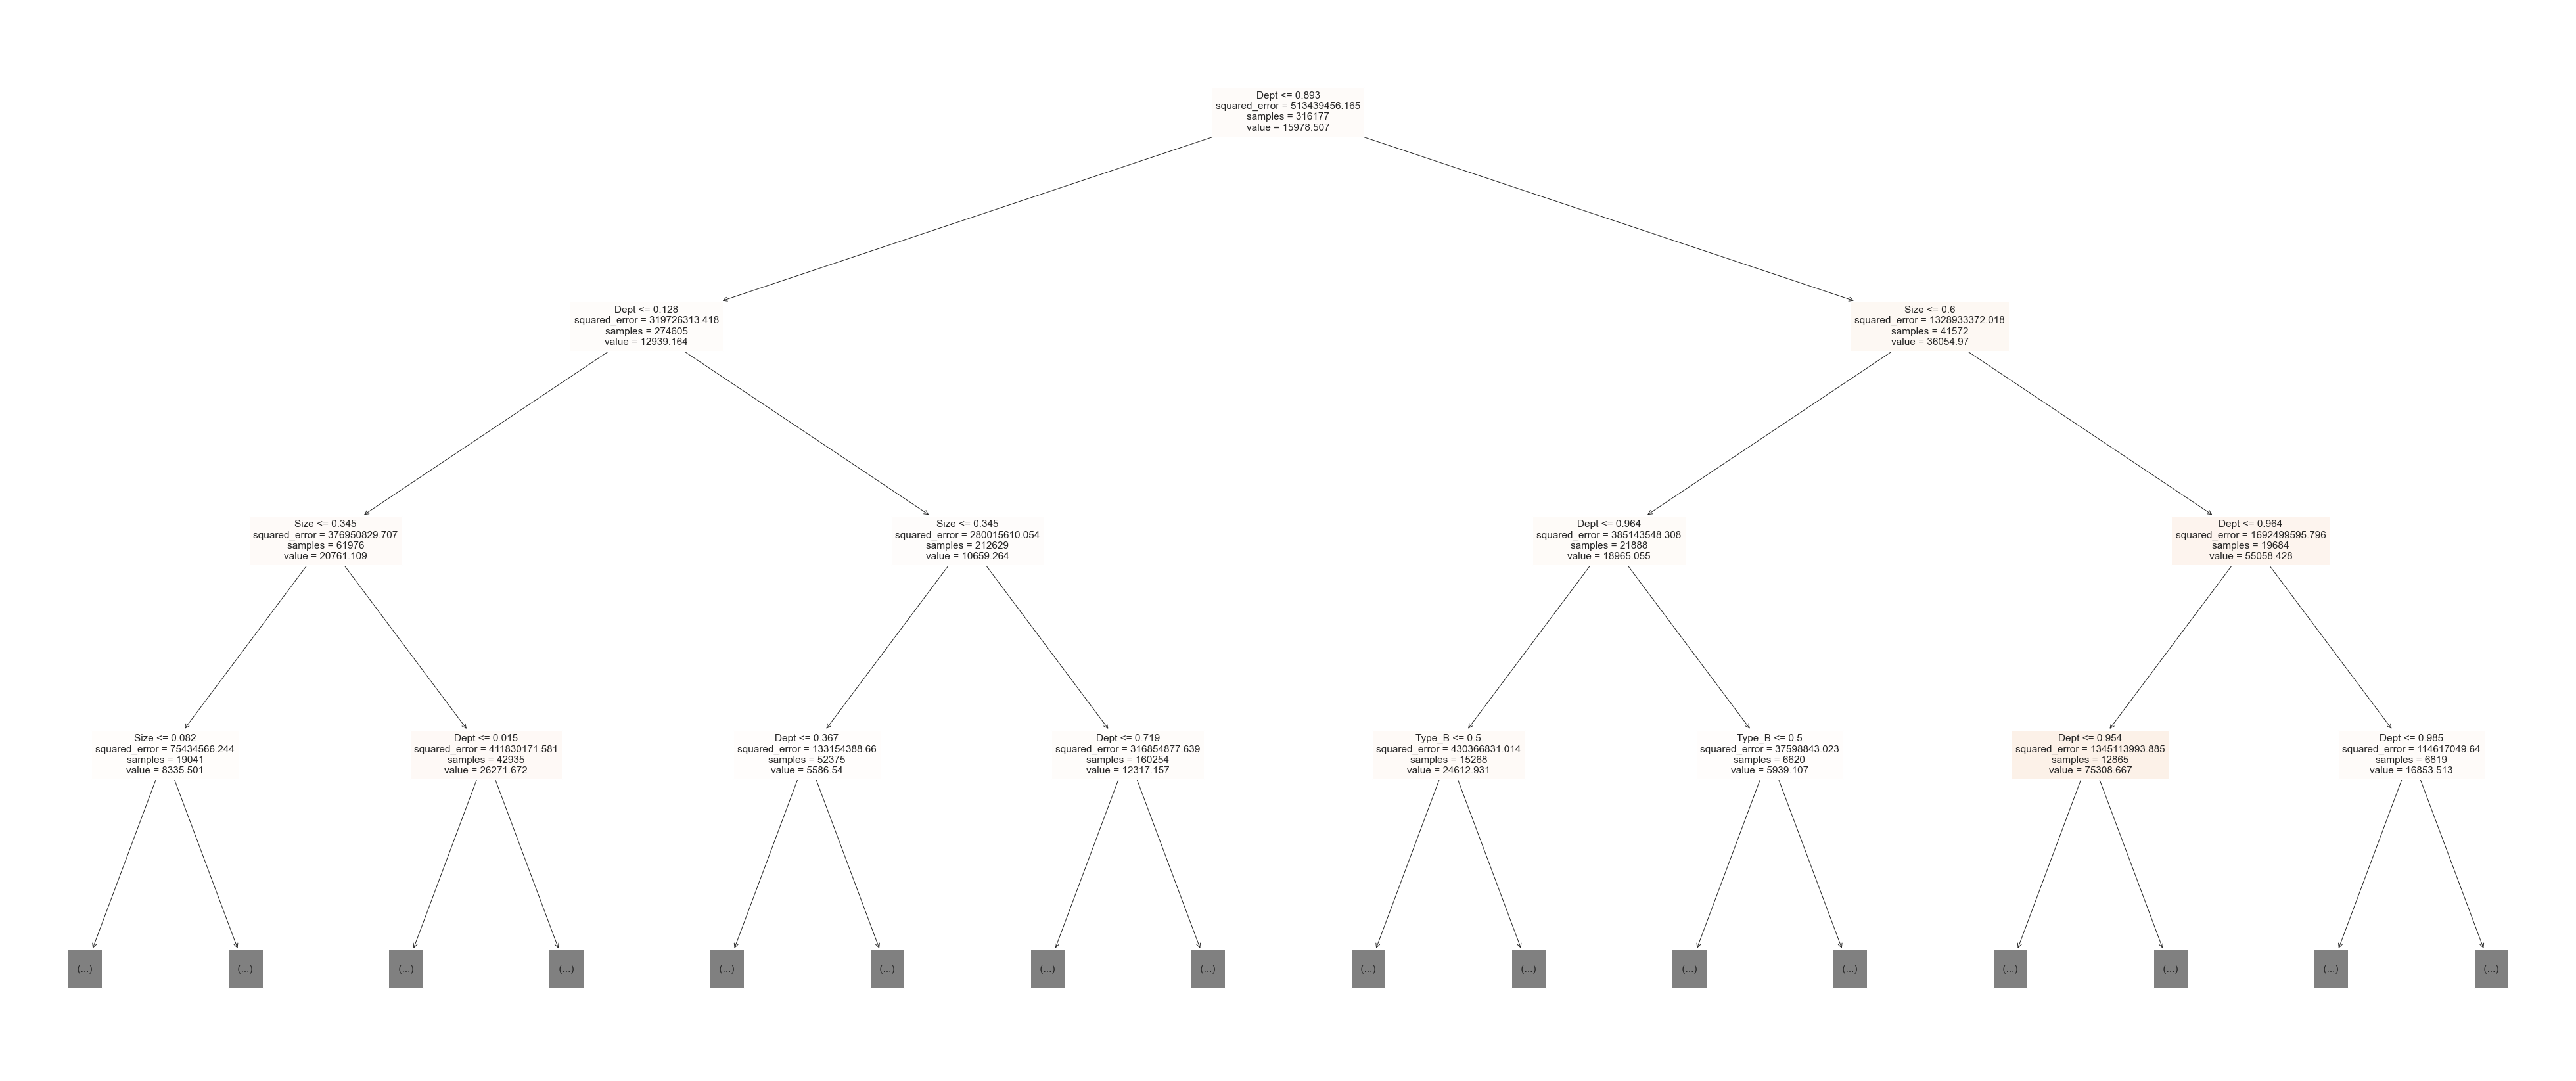

In [46]:
plt.figure(figsize=(70,30))
plot_tree(tree, feature_names=train_inputs.columns, max_depth=3, filled=True);

### Decision Tree feature importance

In [48]:
tree_importances = tree.feature_importances_
tree_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': tree_importances
}).sort_values('importance', ascending=False)

In [49]:
tree_importance_df

,feature,importance
1,Dept,0.636038
2,Size,0.199886
0,Store,0.073534
10,Week,0.056079
12,Type_B,0.011542
5,MarkDown3,0.004413
8,Year,0.003418
6,MarkDown4,0.003338
9,Month,0.003280
11,Type_A,0.002649


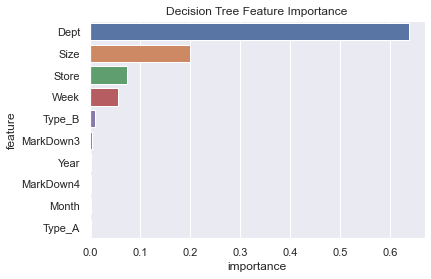

In [50]:
plt.title('Decision Tree Feature Importance')
sns.barplot(data=tree_importance_df.head(10), x='importance', y='feature');

### Random Forests

In [51]:
from sklearn.ensemble import RandomForestRegressor

In [52]:
#When I created the random forest with the default number of estimators (100), the jupyter notebook crashed due to a lack of memory, so let's start with a number of estimators of 10.
rf1 = RandomForestRegressor(random_state=0, n_estimators=10)

In [53]:
%%time
rf1.fit(train_inputs, train_targets)

CPU times: user 9.43 s, sys: 110 ms, total: 9.54 s
Wall time: 9.6 s


RandomForestRegressor(n_estimators=10, random_state=0)

In [55]:
rf1_train_preds = rf1.predict(train_inputs)
rf1_train_rmse = mean_squared_error(train_targets, rf1_train_preds, squared=False)
rf1_val_preds = rf1.predict(val_inputs)
rf1_val_rmse = mean_squared_error(val_targets, rf1_val_preds, squared=False)
print('Train RMSE: {}, Validation RMSE: {}'.format(rf1_train_rmse, rf1_val_rmse))

Train RMSE: 1626.2930490804738, Validation RMSE: 3976.4858753553685


The random forest model shows better results for the validation RMSE, so we will use that model.

### Hyperparameter Tuning


In [56]:
#Let's define a helper function test_params which can test the given value of one or more hyperparameters.

def test_params(**params):
    model = RandomForestRegressor(random_state=0, n_jobs=-1, n_estimators=16, **params).fit(train_inputs, train_targets)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_targets, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_targets, squared=False)
    return train_rmse, val_rmse

In [57]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmse, val_rmse = test_params(**params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

In [58]:
test_params()

(1548.585381266788, 3952.4619494363683)

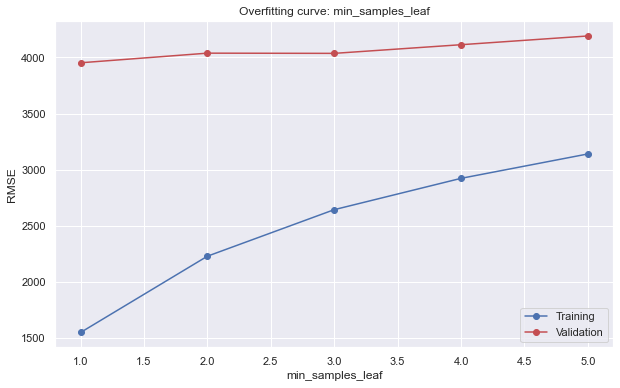

In [59]:
test_param_and_plot('min_samples_leaf', [1, 2, 3, 4, 5])

In [60]:
test_params(min_samples_leaf = 5)

(3139.860605280673, 4191.528032848277)

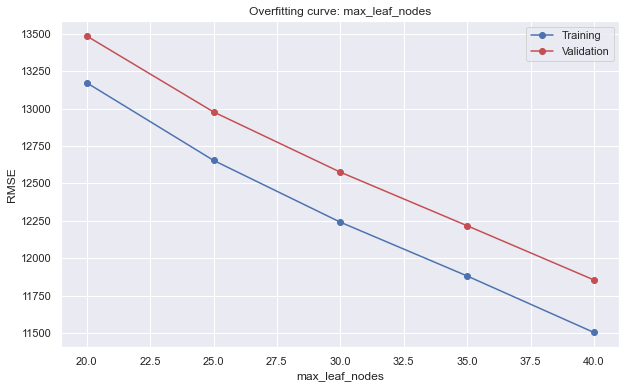

In [61]:
test_param_and_plot('max_leaf_nodes', [20, 25, 30, 35, 40])
#The RMSE decreases with the max_leaf_nodes parameter, so we will use the default value (none).

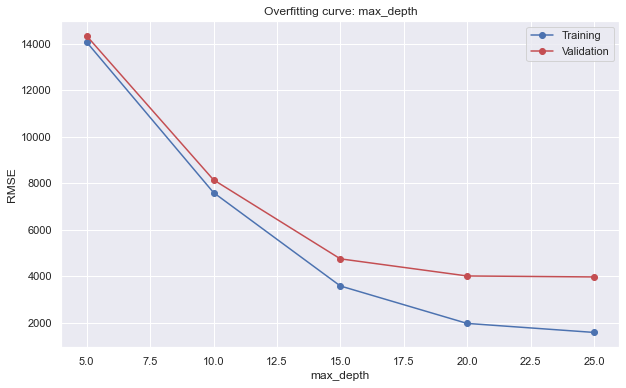

In [62]:
test_param_and_plot('max_depth', [5, 10, 15, 20, 25])

In [63]:
test_params(max_depth = 10)

(7597.636234551192, 8145.9748443797225)

The RMSE decreases with the max_depth parameter, so we will use the default value (none).

Training the Best Model

In [68]:
rf2 = RandomForestRegressor(n_estimators=50, random_state = 0, min_samples_leaf = 1)

In [69]:
rf2.fit(train_inputs, train_targets)

RandomForestRegressor(n_estimators=50, random_state=0)

In [70]:
# Generate predictions for the final model.
rf2_train_preds = rf2.predict(train_inputs)
rf2_train_rmse = mean_squared_error(train_targets, rf2_train_preds, squared=False)
rf2_val_preds = rf2.predict(val_inputs)
rf2_val_rmse = mean_squared_error(val_targets, rf2_val_preds, squared=False)
print('Train RMSE: {}, Validation RMSE: {}'.format(rf2_train_rmse, rf2_val_rmse))

Train RMSE: 1389.8620189760018, Validation RMSE: 3886.524669763337


Random Forest Feature Importance

In [71]:
rf2_importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': rf2.feature_importances_
}).sort_values('importance', ascending=False)

In [72]:
rf2_importance_df

,feature,importance
1,Dept,0.629101
2,Size,0.205501
0,Store,0.071890
10,Week,0.049621
12,Type_B,0.011185
5,MarkDown3,0.008750
9,Month,0.007657
8,Year,0.003436
11,Type_A,0.003276
6,MarkDown4,0.002821


<AxesSubplot:xlabel='importance', ylabel='feature'>

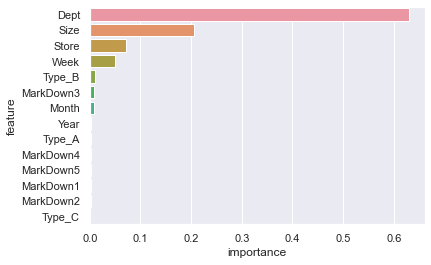

In [73]:
sns.barplot(data=rf2_importance_df, x='importance', y='feature')

### Making Predictions on the Test Set

In [74]:
test_dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4', 'MarkDown5']] = test_dataset[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)
test_dataset['Year'] = pd.to_datetime(test_dataset['Date']).dt.year
test_dataset['Month'] = pd.to_datetime(test_dataset['Date']).dt.month
test_dataset['Week'] = pd.to_datetime(test_dataset['Date']).dt.isocalendar().week
test_dataset = test_dataset.drop(columns=["Date", "CPI", "Fuel_Price", 'Unemployment', 'Temperature'])

In [75]:
test_dataset

,Store,Dept,IsHoliday,Type,Size,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,Year,Month,Week
0,1,1,False,A,151315,6766.44,5147.70,50.82,3639.90,2737.42,2012,11,44
1,1,1,False,A,151315,11421.32,3370.89,40.28,4646.79,6154.16,2012,11,45
2,1,1,False,A,151315,9696.28,292.10,103.78,1133.15,6612.69,2012,11,46
3,1,1,True,A,151315,883.59,4.17,74910.32,209.91,303.32,2012,11,47
4,1,1,False,A,151315,2460.03,0.00,3838.35,150.57,6966.34,2012,11,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,False,B,118221,4842.29,975.03,3.00,2449.97,3169.69,2013,6,26
115060,45,98,False,B,118221,9090.48,2268.58,582.74,5797.47,1514.93,2013,7,27
115061,45,98,False,B,118221,3789.94,1827.31,85.72,744.84,2150.36,2013,7,28
115062,45,98,False,B,118221,2961.49,1047.07,204.19,363.00,1059.46,2013,7,29


In [76]:
test_dataset[numeric_cols] = imputer.transform(test_dataset[numeric_cols])
test_dataset[numeric_cols] = scaler.transform(test_dataset[numeric_cols])
test_dataset[encoded_cols] = encoder.transform(test_dataset[categorical_cols])

In [77]:
test_inputs = test_dataset[numeric_cols + encoded_cols]

In [78]:
test_preds = rf2.predict(test_inputs)

In [79]:
submission_df['Weekly_Sales'] = test_preds

In [80]:
submission_df.to_csv('submission.csv', index=False)

In [81]:
from IPython.display import FileLink
FileLink('submission.csv') # Doesn't work on Colab, use the file browser instead to download the file.

/Users/jaouad/Desktop/submission.csv

### Making Predictions on Single Inputs

In [82]:
def predict_input(model, single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols].values)
    return model.predict(input_df[numeric_cols + encoded_cols])[0]

In [83]:
sample_input = {'Store':9, 'Dept':72, 'IsHoliday':True, 'Type':'B', 'Size':125833, 'MarkDown1':2.5, 'MarkDown2':0.02, 
                'MarkDown3':55952.99, 'MarkDown4':14.64, 'MarkDown5':310.72, 'Year':2012, 'Month':11, 'Week':47}

In [84]:
predicted_price = predict_input(rf2, sample_input)

/opt/homebrew/Caskroom/miniforge/base/envs/ground_env/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [85]:
print('The predicted weekly sales is {}'.format(predicted_price))

The predicted weekly sales is 11197.0


### Saving the Model

In [86]:
import joblib

In [87]:
walmart_sales_rf = {
    'model': rf2,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [88]:
joblib.dump(walmart_sales_rf, 'walmart_sales_rf.joblib')

['walmart_sales_rf.joblib']